## **Importación de las librerías necesarias**

In [1]:
import numpy as np
import pandas as pd
import re
from stop_words import get_stop_words
import matplotlib.pyplot as plt
import seaborn as sns
import stylecloud

OBSERVACIONES:
* Antes de realizar el EDA detallado de los campos más relevantes, se llevará a cabo un ETL de los datsets que se utilizarán en el proyecto de Data Analytics. Esto se realizará con el fin de garantizar la calidad, consistencia y estructura adecuada de los datos, permitiendo realizar un análisis más preciso y confiable.
* El dataset extra `NTSB_aviation_2000-2022.csv` fue extraído de la página oficial de la [National Transportation Safety Board (NTSB)](https://data.ntsb.gov/carol-main-public/query-builder?month=2&year=2021).

## **Dataset: ``AccidentesAviones``**

### **ETL**

* #### **Carga de Datos**

In [216]:
# Los registros que tengan el valor de '?' se consideran como faltantes
df=pd.read_csv("Datasets/AccidentesAviones.csv",na_values="?")
df

,Unnamed: 0,fecha,HORA declarada,Ruta,OperadOR,flight_no,route,ac_type,registration,cn_ln,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary
0,0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,1,"September 07, 1909",NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,2,"July 12, 1912",0630,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,3,"August 06, 1913",NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,4,"September 09, 1913",1830,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5003,5003,"March 28, 2021",1835,"Near Butte, Alaska",Soloy Helicopters,NaN,Sightseeing Charter,Eurocopter AS350B3 Ecureuil,N351SH,4598,6.0,5.0,1.0,5.0,4.0,1.0,0.0,The sightseeing helicopter crashed after missi...
5004,5004,"May 21, 2021",1800,"Near Kaduna, Nigeria",Military - Nigerian Air Force,NaN,NaN,Beechcraft B300 King Air 350i,NAF203,FL-891,11.0,7.0,4.0,11.0,7.0,4.0,0.0,"While on final approach, in poor weather condi..."
5005,5005,"June 10, 2021",0800,"Near Pyin Oo Lwin, Myanmar",Military - Myanmar Air Force,NaN,Naypyidaw - Anisakan,Beechcraft 1900D,4610,E-325,14.0,12.0,2.0,12.0,11.0,1.0,0.0,The plane was carrying military personnel and ...
5006,5006,"July 04, 2021",11:30,"Patikul, Sulu, Philippines",Military - Philippine Air Force,NaN,Cagayan de Oro-Lumbia - Jolo,Lockheed C-130H Hercules,5125,5125,96.0,88.0,8.0,50.0,NaN,NaN,3.0,"While attempting to land at Jolo Airport, the ..."


In [217]:
# Información del Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              5008 non-null   int64  
 1   fecha                   5008 non-null   object 
 2   HORA declarada          3504 non-null   object 
 3   Ruta                    5003 non-null   object 
 4   OperadOR                4998 non-null   object 
 5   flight_no               1326 non-null   object 
 6   route                   4246 non-null   object 
 7   ac_type                 4995 non-null   object 
 8   registration            4736 non-null   object 
 9   cn_ln                   4341 non-null   object 
 10  all_aboard              4991 non-null   float64
 11  PASAJEROS A BORDO       4787 non-null   float64
 12  crew_aboard             4789 non-null   float64
 13  cantidad de fallecidos  5000 non-null   float64
 14  passenger_fatalities    4773 non-null   

* #### **Eliminación de columnas innecesarias**

* `Unnamed: 0`: resulta redundante e innecesaria en el proyecto de data analytics, ya que solo contiene índices mal creados que no ofrecen ninguna información adicional o significativa para el análisis de los datos.
* `flight_no`, `registration` y `cn_ln`: este proyecto se centra en variables relacionadas con los accidentes de aviación, causas probables, lesiones y otros factores más directamente relacionados con los incidentes en sí, en lugar de detalles específicos de vuelo o información de identificación de aeronaves.
* `route`: esta variable redunda con `Ruta`, por lo que no es necesaria.
* `summary`: por tratarse de un resumen o una descripción breve del accidente aéreo, no es necesario para la realización de los dashboards. Pero solo se mantendrá para crear una nube de palabras para el EDA y luego se procederá a eliminar.

In [218]:
df.drop(columns=["Unnamed: 0","flight_no","registration","cn_ln","route"],inplace=True)

* ##### **Campos del tipo fecha y hora**

Conversión del campo ``fecha`` al tipo datetime con formato ``AAAA-mm-dd``

In [219]:
df["fecha"]=pd.to_datetime(df.fecha)

Corrección de los valores incoherentes de la variable ``HORA declarada``

In [220]:
# Visualizando algunos valores del campo
df["HORA declarada"][[0,1,2,3,4,5006,222,228,4742]]

0          1718
1           NaN
2          0630
3           NaN
4          1830
5006      11:30
222     c:17:00
228     c 15:45
4742      0500Z
Name: HORA declarada, dtype: object

In [221]:
# Eliminación de los caracteres que no son numéricos (por simplicidad) y de los ceros iniciales
df['HORA declarada']=df['HORA declarada'].apply(lambda x: re.sub("[^0-9]","",x) if pd.notnull(x) else x)
# Introducción correcta del caracter ':'
df['HORA declarada']=df['HORA declarada'].apply(lambda x: (x[:2]+":"+x[2:] if len(x)==4 else x[0]+":"+x[1:]) if pd.notnull(x) else x)
# Visualición de los resultados
df["HORA declarada"][[0,1,2,3,4,5006,222,228,4742]]

0       17:18
1         NaN
2       06:30
3         NaN
4       18:30
5006    11:30
222     17:00
228     15:45
4742    05:00
Name: HORA declarada, dtype: object

In [222]:
# Porcentaje de valores faltantes
# Se tiene un porcentaje considerable de valores faltantes (30.03%)
round((df[df["HORA declarada"].isnull()].shape[0]/df.shape[0])*100,2)

30.03

In [223]:
# Imputación de valores faltantes con el valor de '0:00', por ser un valor neutral y no afectará al análisis de los datos
df["HORA declarada"]=df["HORA declarada"].fillna("0:00")

In [224]:
# Observando el único error después de los tratamientos aplicados
df[df["HORA declarada"].apply(lambda x: int(x[-2:])>59)]

,fecha,HORA declarada,Ruta,OperadOR,ac_type,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary
3794,1992-10-04,1:75,"Amsterdam, Netherlands",El Al,Boeing B-747-258F,4.0,1.0,3.0,4.0,1.0,3.0,39.0,Shortly after taking off from Schiphol Airport...


In [225]:
# Reemplazando el valor erróneo con el único valor posible
df["HORA declarada"].replace("1:75","17:05",inplace=True)

In [226]:
# Conversión de la columna a tipo datetime
df["HORA declarada"]=pd.to_datetime(df["HORA declarada"],format="%H:%M").dt.time

Unión de los campos de fecha y hora en una sola variable 

In [227]:
df.insert(0,"date",pd.to_datetime(df["fecha"].astype(str) + " " + df["HORA declarada"].astype(str)))

In [228]:
# Eliminación de las columna 'fecha' y 'HORA declarada'
df.drop(columns=["fecha","HORA declarada"],inplace=True)

* ##### **Campo `Ruta`**

In [229]:
# Porcentaje de valores nulos (extremadamente bajo: 0.1%)
print(round((df[df.Ruta.isnull()].shape[0]/df.shape[0])*100,2))
# Imputación de valores faltantes con "unknown"
df.Ruta.fillna("unknown",inplace=True)

0.1


In [230]:
# Visualizando la variable
df.Ruta[:5]

0                   Fort Myer, Virginia
1               Juvisy-sur-Orge, France
2             Atlantic City, New Jersey
3    Victoria, British Columbia, Canada
4                    Over the North Sea
Name: Ruta, dtype: object

In [231]:
# Solo se considerará el nombre del estado o país donde ocurrió el accidente aéreo
df.insert(1,"country",df.Ruta.apply(lambda x: x.split(", ")[-1]))
df.drop(columns="Ruta",inplace=True)

* ##### **Campo `OperadOR`**

In [232]:
# Porcentaje de valores nulos (extremadamente bajo: 0.2%)
print(round((df[df.OperadOR.isnull()].shape[0]/df.shape[0])*100,2))
# Imputación de valores faltantes con "unknown"
df.OperadOR.fillna("unknown",inplace=True)

0.2


In [233]:
# Visualizando la variable
df.OperadOR[:5]

0      Military - U.S. Army
1                   unknown
2      Military - U.S. Navy
3                   Private
4    Military - German Navy
Name: OperadOR, dtype: object

In [234]:
# Solo se considerará el nombre de la compañía aérea o entidad relacionada con la operación de vuelo
df.insert(2,"operator",df.OperadOR.apply(lambda x: x.split(" - ")[-1]))
df.drop(columns="OperadOR",inplace=True)

In [235]:
# Visualización del resultado
df.operator[:5]

0      U.S. Army
1        unknown
2      U.S. Navy
3        Private
4    German Navy
Name: operator, dtype: object

* ##### **Imputación de valores faltantes de `ac_type`**

In [236]:
# Porcentaje de valores nulos (extremadamente bajo: 0.26%)
print(round((df[df.ac_type.isnull()].shape[0]/df.shape[0])*100,2))
# Imputación de valores faltantes con "unknown"
df.ac_type.fillna("unknown",inplace=True)

0.26


* ##### **Imputación de valores faltantes de las columnas del tipo `float`**

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    5008 non-null   datetime64[ns]
 1   country                 5008 non-null   object        
 2   operator                5008 non-null   object        
 3   ac_type                 5008 non-null   object        
 4   all_aboard              4991 non-null   float64       
 5   PASAJEROS A BORDO       4787 non-null   float64       
 6   crew_aboard             4789 non-null   float64       
 7   cantidad de fallecidos  5000 non-null   float64       
 8   passenger_fatalities    4773 non-null   float64       
 9   crew_fatalities         4773 non-null   float64       
 10  ground                  4964 non-null   float64       
 11  summary                 4949 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(4)
memo

In [238]:
# Porcentaje de valores nulos de la variable con mayor cantidad faltantes (bajo: 4.69%)
print(round((df[df.passenger_fatalities.isnull()].shape[0]/df.shape[0])*100,2))

4.69


Columnas: `all_aboard`, `PASAJEROS A BORDO` y `crew_aboard`

In [239]:
# Se concluye que: 'all_aboard' = 'PASAJEROS A BORDO' + 'crew_aboard'
df[df["all_aboard"]>0][["all_aboard","PASAJEROS A BORDO","crew_aboard"]]

,all_aboard,PASAJEROS A BORDO,crew_aboard
0,2.0,1.0,1.0
1,1.0,0.0,1.0
2,5.0,0.0,5.0
3,1.0,0.0,1.0
4,20.0,NaN,NaN
...,...,...,...
5003,6.0,5.0,1.0
5004,11.0,7.0,4.0
5005,14.0,12.0,2.0
5006,96.0,88.0,8.0


In [240]:
# Caso 1: cuando el total de personas a bordo es nulo
print(df[df["all_aboard"].isnull()][["all_aboard","PASAJEROS A BORDO","crew_aboard"]])

# Se imputa con el valor de cero para no alterar el análisis de datos
df.all_aboard.fillna(0,inplace=True)

      all_aboard  PASAJEROS A BORDO  crew_aboard
26           NaN                NaN          NaN
103          NaN                NaN          NaN
347          NaN                NaN          NaN
384          NaN                NaN          NaN
451          NaN                NaN          NaN
652          NaN                NaN          NaN
754          NaN                NaN          NaN
854          NaN                NaN          NaN
1231         NaN                NaN          NaN
1362         NaN                NaN          NaN
1386         NaN                NaN          NaN
1451         NaN                NaN          NaN
1577         NaN                NaN          NaN
1627         NaN                NaN          NaN
1638         NaN                NaN          NaN
3553         NaN                NaN          NaN
3752         NaN                NaN          NaN


In [241]:
# Caso 2: cuando 'PASAJEROS A BORDO' o 'crew_aboard' es nulo
print(df[((df["PASAJEROS A BORDO"].isnull())&(df.crew_aboard.notnull())) | 
         ((df["PASAJEROS A BORDO"].notnull())&(df.crew_aboard.isnull()))][["all_aboard","PASAJEROS A BORDO","crew_aboard"]])

# Se imputa con la diferencia entre el total y el otro campo respectivo
df["PASAJEROS A BORDO"]=df.apply(lambda x: x.all_aboard-x.crew_aboard if pd.isnull(x["PASAJEROS A BORDO"]) and pd.notnull(x.crew_aboard) 
                                 else x["PASAJEROS A BORDO"],axis=1)

df["crew_aboard"]=df.apply(lambda x: x.all_aboard-x["PASAJEROS A BORDO"] if pd.notnull(x["PASAJEROS A BORDO"]) and pd.isnull(x.crew_aboard) 
                                 else x.crew_aboard,axis=1)

      all_aboard  PASAJEROS A BORDO  crew_aboard
165          3.0                NaN          3.0
1306        13.0                NaN         13.0
1825         9.0                NaN          9.0
4924        72.0               72.0          NaN


In [242]:
# Caso 3: cuando 'PASAJEROS A BORDO' y 'crew_aboard' son nulos
print(df[(df["PASAJEROS A BORDO"].isnull()) & (df.crew_aboard.isnull())][["all_aboard","PASAJEROS A BORDO","crew_aboard"]])
"""
Se imputará con el porcentaje del campo respectivo respecto al total con ayuda del campo 'all_aboard', para que la 
distribución de las variables no se altere.
"""
percentage=df["PASAJEROS A BORDO"].sum()/(df["PASAJEROS A BORDO"].sum()+df.crew_aboard.sum())
print(percentage)

df["PASAJEROS A BORDO"]=df.apply(lambda x: round(x.all_aboard*percentage) if pd.isnull(x["PASAJEROS A BORDO"]) and pd.isnull(x.crew_aboard) 
                                 else x["PASAJEROS A BORDO"],axis=1)

df["crew_aboard"]=df.apply(lambda x: x.all_aboard-x["PASAJEROS A BORDO"] if pd.isnull(x.crew_aboard) else x.crew_aboard,axis=1)

      all_aboard  PASAJEROS A BORDO  crew_aboard
4           20.0                NaN          NaN
5           28.0                NaN          NaN
7           19.0                NaN          NaN
8           20.0                NaN          NaN
9           22.0                NaN          NaN
...          ...                ...          ...
4786        28.0                NaN          NaN
4791        10.0                NaN          NaN
4802        23.0                NaN          NaN
4813        38.0                NaN          NaN
4833        12.0                NaN          NaN

[218 rows x 3 columns]
0.8560004257980387


In [243]:
# Caso 4: cuando 'all_aboard' != 'PASAJEROS A BORDO' + 'crew_aboard'. Son en total 31 filas.
print(df[df.all_aboard!=df["PASAJEROS A BORDO"]+df.crew_aboard].head(10)[["all_aboard","PASAJEROS A BORDO","crew_aboard"]])

# Por simplicidad al ser pocos valores, 'all_aboard' se corrige con la suma de 'PASAJEROS A BORDO' con 'crew_aboard'
df["all_aboard"]=df.apply(lambda x: x["PASAJEROS A BORDO"]+x.crew_aboard if x.all_aboard != x["PASAJEROS A BORDO"]+x.crew_aboard 
                          else x.all_aboard,axis=1)

      all_aboard  PASAJEROS A BORDO  crew_aboard
30           0.0                0.0          1.0
32           1.0                1.0          1.0
39           1.0                1.0          1.0
55           2.0                0.0          0.0
120          0.0                0.0          2.0
213          3.0                0.0          2.0
495          2.0                0.0          0.0
498          3.0                0.0          0.0
1121         0.0                1.0          1.0
1170         4.0                0.0          2.0


Columnas: ``cantidad de fallecidos``, ``passenger_fatalities`` y ``crew_fatalities``

In [244]:
"""
Se concluye que: 'cantidad de fallecidos' = 'passenger_fatalities' + 'crew_fatalities', además de que 'ground' es independiente 
de estas 3 variables
"""
print(df[df["cantidad de fallecidos"]>0][["cantidad de fallecidos","passenger_fatalities","crew_fatalities","ground"]])
print(df[(df["cantidad de fallecidos"]>0)&(df.ground>0)][["cantidad de fallecidos","passenger_fatalities","crew_fatalities","ground"]])

# Se imputa con cero los valores faltantes de 'ground' por tan solo tener 44 nulos (según la información del data frame)
df.ground.fillna(0,inplace=True)

      cantidad de fallecidos  passenger_fatalities  crew_fatalities  ground
0                        1.0                   1.0              0.0     0.0
1                        1.0                   0.0              0.0     0.0
2                        5.0                   0.0              5.0     0.0
3                        1.0                   0.0              1.0     0.0
4                       14.0                   NaN              NaN     0.0
...                      ...                   ...              ...     ...
5003                     5.0                   4.0              1.0     0.0
5004                    11.0                   7.0              4.0     0.0
5005                    12.0                  11.0              1.0     0.0
5006                    50.0                   NaN              NaN     3.0
5007                    28.0                  22.0              6.0     0.0

[4924 rows x 4 columns]
      cantidad de fallecidos  passenger_fatalities  crew_fatali

In [246]:
# Caso 1: cuando el total de personas fallecidas es nula
print(df[df["cantidad de fallecidos"].isnull()][["cantidad de fallecidos","passenger_fatalities","crew_fatalities"]])

# Se imputa con el valor de cero para no alterar el análisis de datos
df["cantidad de fallecidos"].fillna(0,inplace=True)

      cantidad de fallecidos  passenger_fatalities  crew_fatalities
103                      NaN                   NaN              NaN
347                      NaN                   NaN              NaN
384                      NaN                   NaN              NaN
451                      NaN                   NaN              NaN
652                      NaN                   NaN              NaN
754                      NaN                   NaN              NaN
854                      NaN                   NaN              NaN
1451                     NaN                   NaN              NaN


In [247]:
# Caso 2: cuando 'passenger_fatalities' o 'crew_fatalities' es nulo
print(df[((df.passenger_fatalities.isnull())&(df.crew_fatalities.notnull())) | 
         ((df.passenger_fatalities.notnull())&(df.crew_fatalities.isnull()))][["cantidad de fallecidos","passenger_fatalities","crew_fatalities"]])

# Se imputa con la diferencia entre el total y el otro campo respectivo
df["passenger_fatalities"]=df.apply(lambda x: x["cantidad de fallecidos"]-x.crew_fatalities if pd.isnull(x.passenger_fatalities) and pd.notnull(x.crew_fatalities) 
                                 else x["passenger_fatalities"],axis=1)

df["crew_fatalities"]=df.apply(lambda x: x["cantidad de fallecidos"]-x.passenger_fatalities if pd.notnull(x.passenger_fatalities) and pd.isnull(x.crew_fatalities) 
                                 else x.crew_fatalities,axis=1)

      cantidad de fallecidos  passenger_fatalities  crew_fatalities
334                      4.0                   3.0              NaN
628                     11.0                   NaN              4.0
947                     21.0                  17.0              NaN
1306                    13.0                   NaN             13.0
1577                     1.0                   1.0              NaN
1825                     9.0                   NaN              9.0
4770                    12.0                   NaN              3.0
4924                     1.0                   1.0              NaN


In [248]:
# Caso 3: cuando 'passenger_fatalities' y 'crew_fatalities' son nulos
print(df[(df.passenger_fatalities.isnull()) & (df.crew_fatalities.isnull())][["cantidad de fallecidos","passenger_fatalities","crew_fatalities"]])
"""
Se imputará con el porcentaje del campo respectivo respecto al total con ayuda del campo 'cantidad de fallecidos', para que la 
distribución de las variables no se altere.
"""
percentage2=df.passenger_fatalities.sum()/(df.passenger_fatalities.sum()+df.crew_fatalities.sum())
print(percentage2)

df["passenger_fatalities"]=df.apply(lambda x: round(x["cantidad de fallecidos"]*percentage2) if pd.isnull(x.passenger_fatalities) and pd.isnull(x.crew_fatalities) 
                                 else x.passenger_fatalities,axis=1)

df["crew_fatalities"]=df.apply(lambda x: x["cantidad de fallecidos"]-x.passenger_fatalities if pd.isnull(x.crew_fatalities) 
                               else x.crew_fatalities,axis=1)

      cantidad de fallecidos  passenger_fatalities  crew_fatalities
4                       14.0                   NaN              NaN
5                       28.0                   NaN              NaN
7                       19.0                   NaN              NaN
8                       20.0                   NaN              NaN
9                       22.0                   NaN              NaN
...                      ...                   ...              ...
4813                    38.0                   NaN              NaN
4833                    12.0                   NaN              NaN
4848                    15.0                   NaN              NaN
4894                    18.0                   NaN              NaN
5006                    50.0                   NaN              NaN

[231 rows x 3 columns]
0.8407486959189936


In [249]:
# Caso 4: cuando 'cantidad de fallecidos' != 'passenger_fatalities' + 'crew_fatalities'. Son en total 41 filas.
print(df[df["cantidad de fallecidos"]!=df.passenger_fatalities+df.crew_fatalities].head(10)[["cantidad de fallecidos","passenger_fatalities","crew_fatalities"]])

# Por simplicidad al ser pocos valores, 'cantidad de fallecidos' se corrige con la suma de 'passenger_fatalities' con 'crew_fatalities'
df["cantidad de fallecidos"]=df.apply(lambda x: x.passenger_fatalities+x.crew_fatalities if x["cantidad de fallecidos"] != x.passenger_fatalities+x.crew_fatalities
                                      else x["cantidad de fallecidos"],axis=1)

     cantidad de fallecidos  passenger_fatalities  crew_fatalities
1                       1.0                   0.0              0.0
32                      1.0                   1.0              1.0
39                      1.0                   1.0              1.0
55                      2.0                   0.0              0.0
120                     0.0                   0.0              2.0
178                     2.0                   7.0              2.0
186                     4.0                   3.0              2.0
361                     0.0                   0.0              2.0
381                     1.0                   3.0              0.0
402                    12.0                   9.0              1.0


* ##### **Imputación de valores faltantes de la variable `summary` (solo para el EDA)**

In [251]:
# Se imputarán con cadenas vacías para que el wordcloud interprete la ausencia de información como una carcaterística adicional
df.summary.fillna("",inplace=True)

Transformaciones adicionales

In [252]:
# Conversión a minúsculas
df["summary"]=df.summary.apply(lambda x: x.lower())

# Implementando una función que realize el trabajo antes descrito
def preprocess_text(text):
    #Eliminación de los signos de puntuación utilizando con la librería regex
    text=re.sub(r"[^\w\s]","",text)
    #Eliminación de las palabras irrelevantes utilizando la librería stop_words
    stop_word=get_stop_words("english")
    text=text.split()
    text=[word for word in text if word not in stop_word]
    return text

df["summary"]=df.summary.apply(preprocess_text)

* ##### **Visualización del resultado del ETL**

In [253]:
df.head(3)

,date,country,operator,ac_type,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary
0,1908-09-17 17:18:00,Virginia,U.S. Army,Wright Flyer III,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"[demonstration, flight, us, army, flyer, flown..."
1,1909-09-07 00:00:00,France,unknown,Wright Byplane,1.0,0.0,1.0,0.0,0.0,0.0,0.0,"[eugene, lefebvre, first, pilot, ever, killed,..."
2,1912-07-12 06:30:00,New Jersey,U.S. Navy,Dirigible,5.0,0.0,5.0,5.0,0.0,5.0,0.0,"[first, us, dirigible, akron, exploded, just, ..."


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    5008 non-null   datetime64[ns]
 1   country                 5008 non-null   object        
 2   operator                5008 non-null   object        
 3   ac_type                 5008 non-null   object        
 4   all_aboard              5008 non-null   float64       
 5   PASAJEROS A BORDO       5008 non-null   float64       
 6   crew_aboard             5008 non-null   float64       
 7   cantidad de fallecidos  5008 non-null   float64       
 8   passenger_fatalities    5008 non-null   float64       
 9   crew_fatalities         5008 non-null   float64       
 10  ground                  5008 non-null   float64       
 11  summary                 5008 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(4)
memo

### **Análisis Exploratorio de Datos (EDA)**

#### **``Análisis Univariado``**

* #### **Estadísticas descriptivas de las variables numéricas**

In [255]:
df.describe()

,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground
count,5008.000000,5008.000000,5008.000000,5008.000000,5008.000000,5008.000000,5008.000000
mean,31.025958,26.558906,4.467053,22.326877,18.770966,3.555911,1.703275
std,45.441312,43.364551,3.776050,35.105359,33.386810,3.154321,55.251400
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,3.000000,2.000000,4.000000,1.000000,2.000000,0.000000
50%,16.000000,12.000000,4.000000,11.000000,8.000000,3.000000,0.000000
75%,35.000000,30.000000,6.000000,25.000000,21.000000,5.000000,0.000000
max,644.000000,614.000000,83.000000,583.000000,560.000000,43.000000,2750.000000


* #### **Diagrama de Cajas de las variables numéricas**

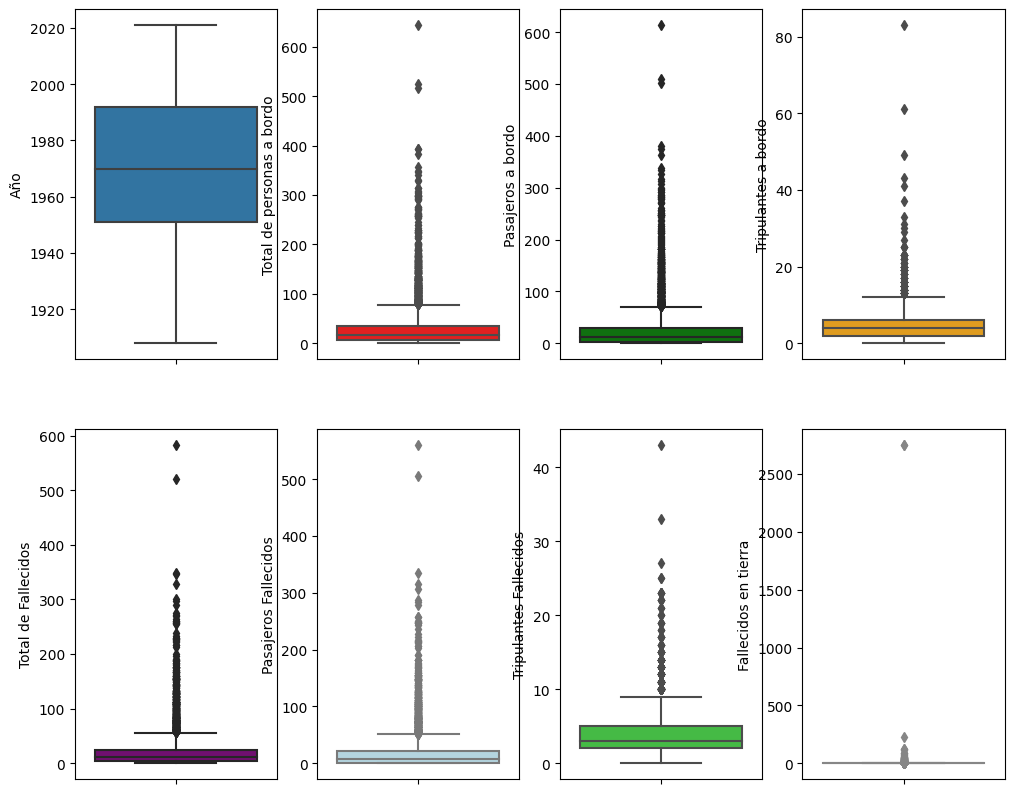

In [256]:
fig,ax=plt.subplots(2,4,figsize=(12,10))

sns.boxplot(y=df.date.dt.year,data=df,ax=ax[0,0])
ax[0,0].set_ylabel("Año")

sns.boxplot(y="all_aboard",data=df,ax=ax[0,1],color="red")
ax[0,1].set_ylabel("Total de personas a bordo")

sns.boxplot(y="PASAJEROS A BORDO",data=df,ax=ax[0,2],color="green")
ax[0,2].set_ylabel("Pasajeros a bordo")

sns.boxplot(y="crew_aboard",data=df,ax=ax[0,3],color="#FFA500")
ax[0,3].set_ylabel("Tripulantes a bordo")

sns.boxplot(y="cantidad de fallecidos",data=df,ax=ax[1,0],color="#800080")
ax[1,0].set_ylabel("Total de Fallecidos")

sns.boxplot(y="passenger_fatalities",data=df,ax=ax[1,1],color="#ADD8E6")
ax[1,1].set_ylabel("Pasajeros Fallecidos")

sns.boxplot(y="crew_fatalities",data=df,ax=ax[1,2],color="limegreen")
ax[1,2].set_ylabel("Tripulantes Fallecidos")

sns.boxplot(y="ground",data=df,ax=ax[1,3],color="pink")
ax[1,3].set_ylabel("Fallecidos en tierra");

CONCLUSIÓN: Al analizar los años de la variable ``date``, se observa que no presenta valores atípicos (outliers), lo que indica que los años están concentrados en torno a una región central. Esto sugiere que los registros se distribuyen de manera relativamente uniforme a lo largo del tiempo sin eventos extremos o inusuales.

Por otro lado, al examinar las variables relacionadas con las personas involucradas en los accidentes aéreos, se identifican múltiples outliers superiores. Esta observación sugiere la presencia de un número reducido de accidentes aéreos con una alta cantidad de personas a bordo o un alto número de personas fallecidas. Estos valores atípicos indican casos excepcionales en los que el impacto humano y las consecuencias fueron significativamente mayores en comparación con la mayoría de los accidentes aéreos registrados.

* #### **Histogramas de las variables numéricas**

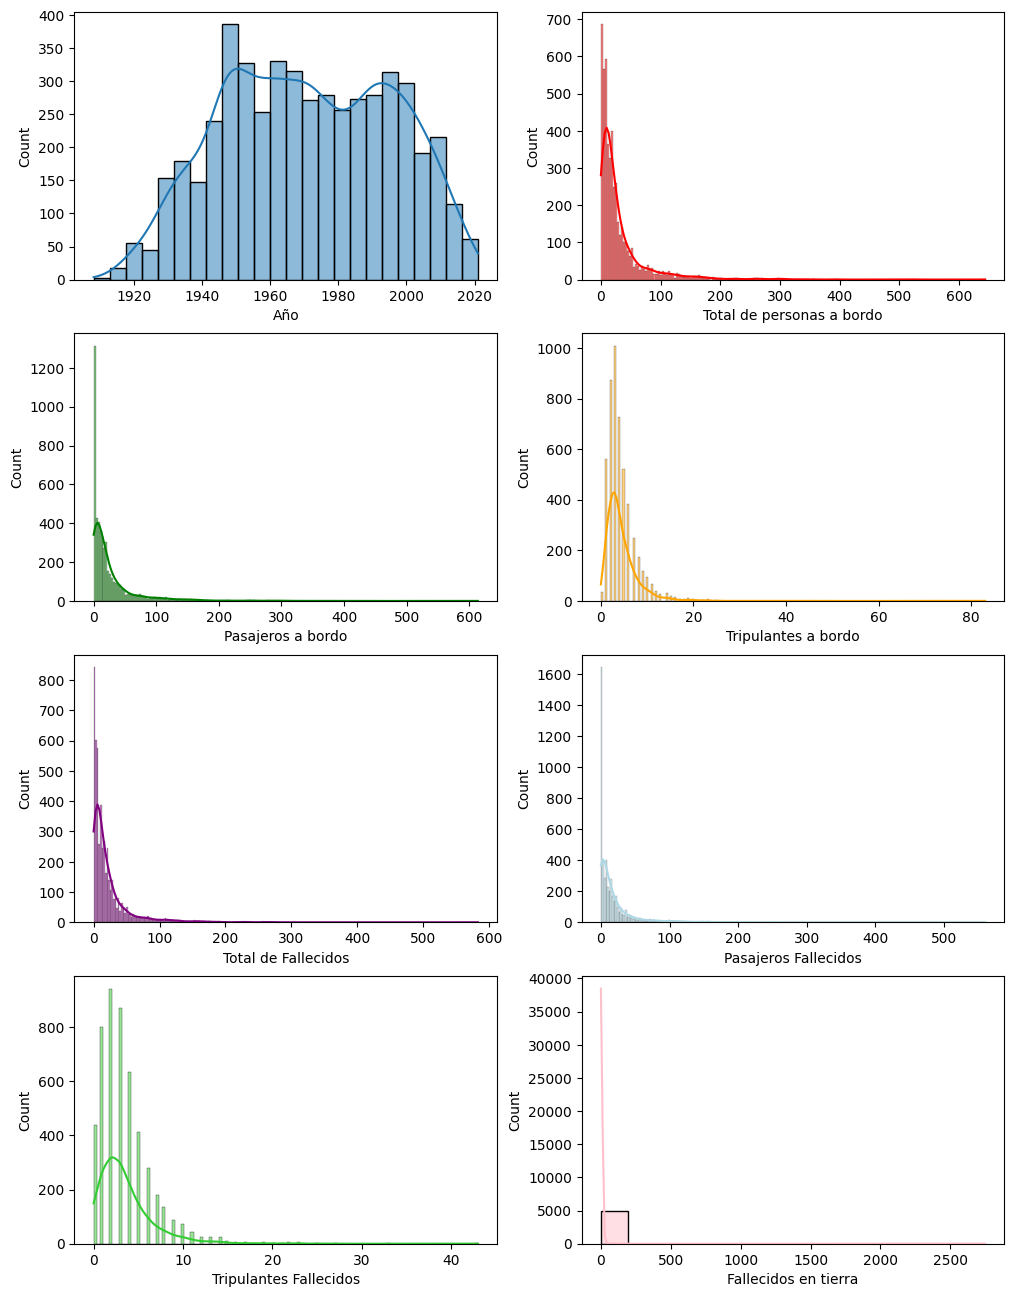

In [257]:
fig,ax=plt.subplots(4,2,figsize=(12,16))

sns.histplot(x=df.date.dt.year,data=df,ax=ax[0,0],kde=True)
ax[0,0].set_xlabel("Año")

sns.histplot(x="all_aboard",data=df,ax=ax[0,1],color="red",kde=True)
ax[0,1].set_xlabel("Total de personas a bordo")

sns.histplot(x="PASAJEROS A BORDO",data=df,ax=ax[1,0],color="green",kde=True)
ax[1,0].set_xlabel("Pasajeros a bordo")

sns.histplot(x="crew_aboard",data=df,ax=ax[1,1],color="#FFA500",kde=True)
ax[1,1].set_xlabel("Tripulantes a bordo")

sns.histplot(x="cantidad de fallecidos",data=df,ax=ax[2,0],color="#800080",kde=True)
ax[2,0].set_xlabel("Total de Fallecidos")

sns.histplot(x="passenger_fatalities",data=df,ax=ax[2,1],color="#ADD8E6",kde=True)
ax[2,1].set_xlabel("Pasajeros Fallecidos")

sns.histplot(x="crew_fatalities",data=df,ax=ax[3,0],color="limegreen",kde=True)
ax[3,0].set_xlabel("Tripulantes Fallecidos")

sns.histplot(x="ground",data=df,ax=ax[3,1],color="pink",kde=True)
ax[3,1].set_xlabel("Fallecidos en tierra");

CONCLUSIÓN: 
Los años de la variable ``date`` muestran una distribución multimodal con un pico principal alrededor de 1950. Esto indica que la frecuencia de accidentes aéreos ha mantenido un nivel relativamente constante a lo largo del tiempo, con períodos de incremento y disminución en diferentes intervalos. La presencia de múltiples picos sugiere posibles cambios en la seguridad y las regulaciones aéreas a lo largo de las décadas.

Por otro lado, al analizar las demás variables relacionadas, se observa una distribución sesgada hacia la derecha con picos principales cercanos a cero o en cero. Esto implica que en la mayoría de los accidentes aéreos registrados, la cantidad de fallecidos o personas a bordo es baja o nula. Sin embargo, es importante tener en cuenta que la distribución sesgada hacia la derecha también indica la presencia de un número reducido de casos excepcionales con un alto número de fallecidos o personas a bordo, lo que puede corresponder a accidentes aéreos de gran magnitud y consecuencias trágicas.

* #### **Barplots (Gráficos de Barras)  de las variables categóricas**

Los barplots muestran los 20 valores principales de las variables categóricas principales. Al visualizarlos, se pueden extraer conclusiones relevantes de manera rápida y efectiva.

##### Variable ``country``

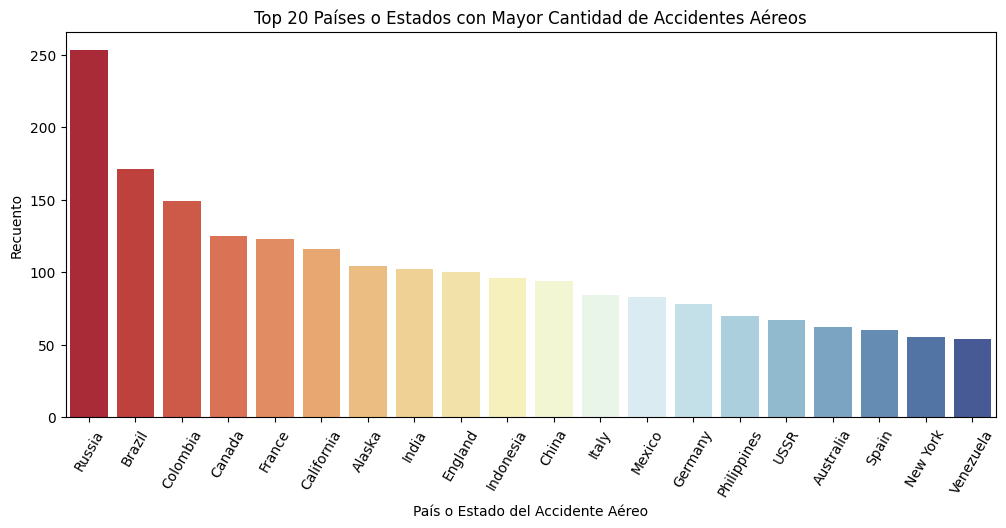

In [266]:
top_country=df.country.value_counts().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,5))
sns.barplot(x=top_country.index,y=top_country,palette='RdYlBu')
plt.xlabel('País o Estado del Accidente Aéreo')
plt.ylabel('Recuento')
plt.title('Top 20 Países o Estados con Mayor Cantidad de Accidentes Aéreos')
plt.xticks(rotation=60);

##### Variable ``operator``

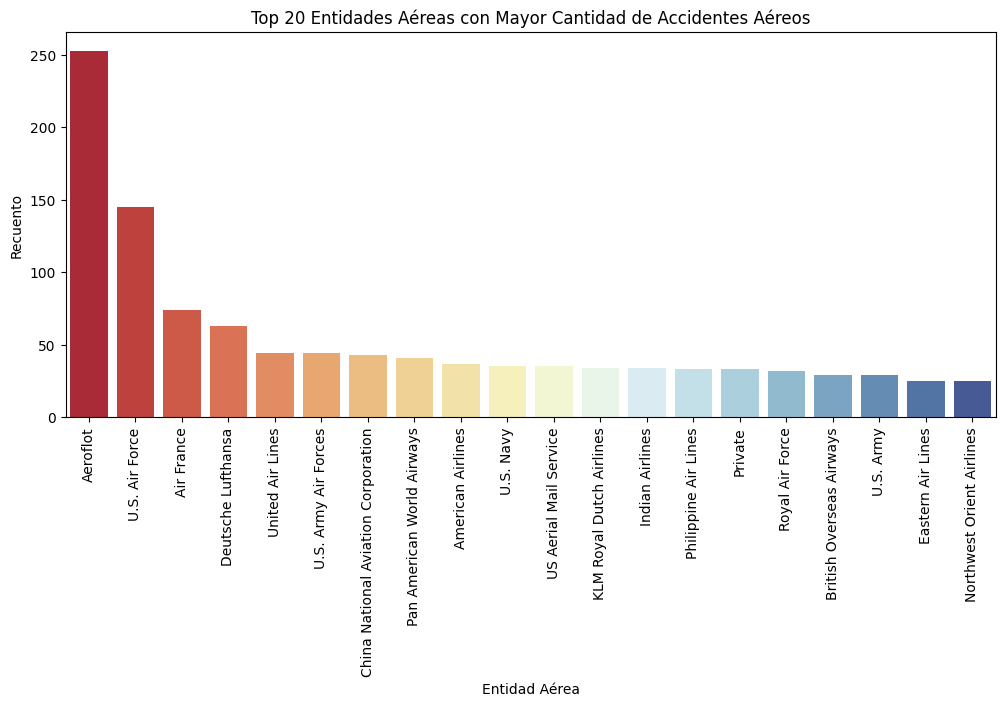

In [267]:
top_operator=df.operator.value_counts().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,5))
sns.barplot(x=top_operator.index,y=top_operator,palette='RdYlBu')
plt.xlabel('Entidad Aérea')
plt.ylabel('Recuento')
plt.title('Top 20 Entidades Aéreas con Mayor Cantidad de Accidentes Aéreos')
plt.xticks(rotation=90);

##### Variable ``ac_type``

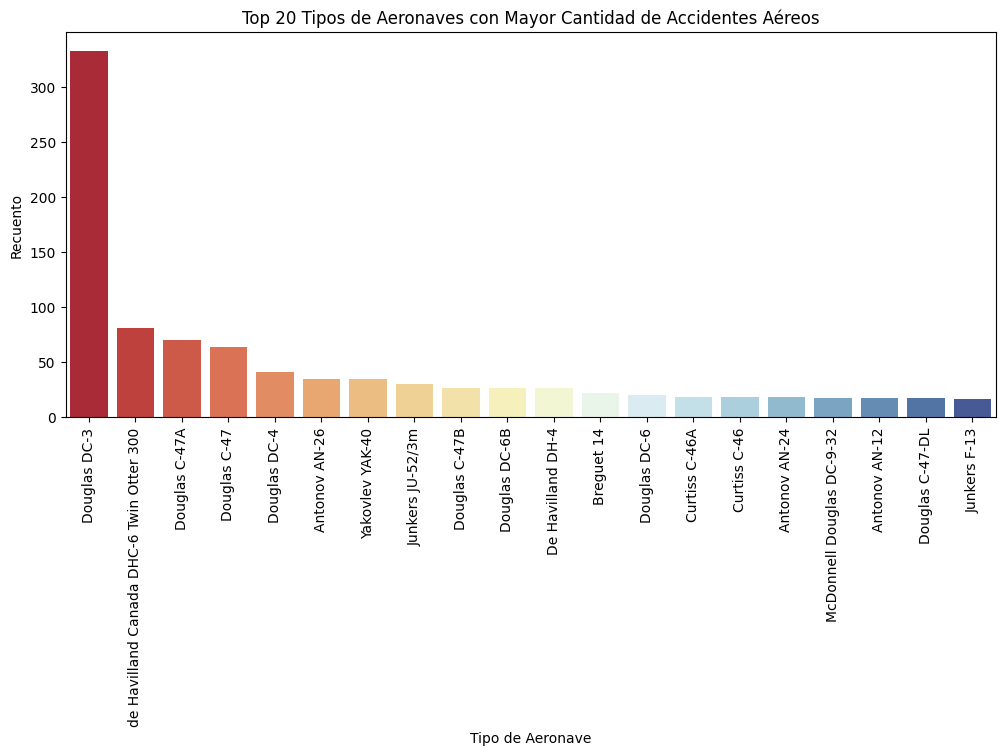

In [268]:
top_ac_type=df.ac_type.value_counts().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,5))
sns.barplot(x=top_ac_type.index,y=top_ac_type,palette='RdYlBu')
plt.xlabel('Tipo de Aeronave')
plt.ylabel('Recuento')
plt.title('Top 20 Tipos de Aeronaves con Mayor Cantidad de Accidentes Aéreos')
plt.xticks(rotation=90);

* #### **Word Cloud: variable `summary`**

In [392]:
# Creamos una variable donde estén unidas todas las palabras de todas las filas de la columna 'summary'
text=" ".join(df.summary.str.join(" "))
# Generamos una imagen que contenga las palabras que más se repiten en la columna 'overview'
stylecloud.gen_stylecloud(text=text,
                          icon_name="fas fa-cloud",
                          background_color="black",
                          output_name="summary_wordcloud.png")

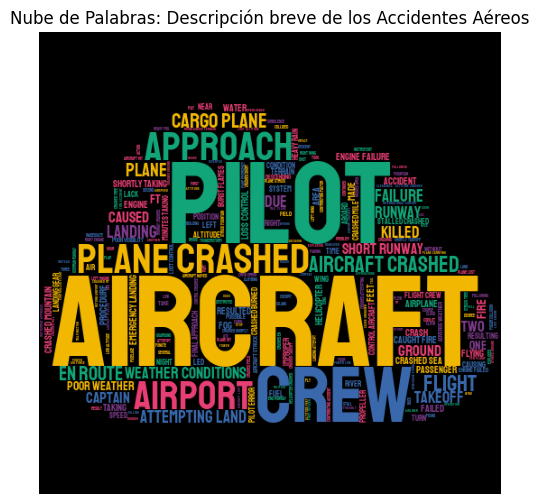

In [393]:
image=plt.imread('Datasets/summary_wordcloud.png')
plt.figure(figsize=(8,6))
plt.title("Nube de Palabras: Descripción breve de los Accidentes Aéreos")
plt.imshow(image)
plt.axis('off');

CONCLUSIÓN: Mediante este gráfico, podemos observar las palabras más frecuentes en las descripciones de los accidentes aéreos. Una de las palabras con mayor tamaño es 'plane crashed', concluyendo que la colisión de la aeronave es un escenario común en la mayoría de los accidentes aéreos.

#### **``Análisis Bivariado``**

* #### **Heatmap de las variables numéricas**

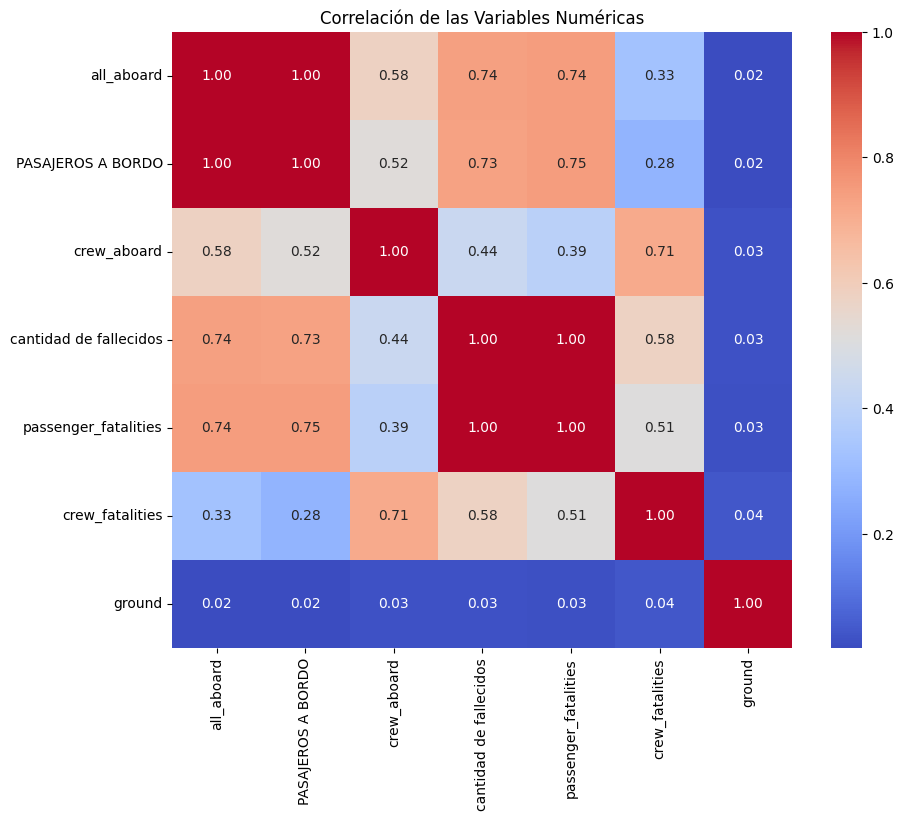

In [269]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True),annot=True,fmt=".2f",cmap="coolwarm")
plt.title("Correlación de las Variables Numéricas");

CONCLUSIÓN: Del heatmap se desprende que todas las combinaciones de variables presentan una correlación positiva, lo que implica que a medida que una variable aumenta, las demás también tienden a aumentar. Es interesante destacar las correlaciones más fuertes entre las variables ``PASAJEROS A BORDO``, ``all_aboard``, ``cantidad de fallecidos`` y ``passenger_fatalities``. Estos resultados respaldan la idea de que a medida que aumenta el número de pasajeros a bordo de la aeronave, también se incrementa la cantidad de fallecidos en los accidentes aéreos. Esta relación sugiere que la presencia de más pasajeros aumenta el riesgo de fatalidades en caso de un accidente.

* #### **Barplot: Cantidad de Personas Fallecidas por Año**

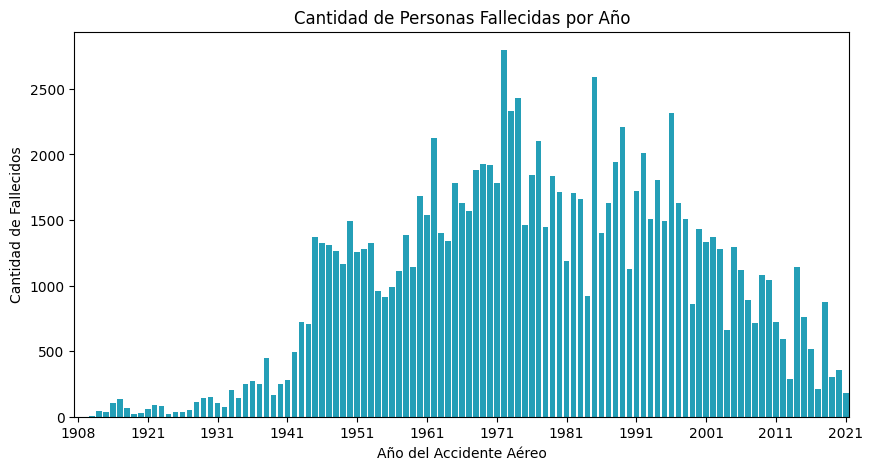

In [270]:
df_b1=df.groupby(df.date.dt.year)["cantidad de fallecidos"].sum()
plt.figure(figsize=(10,5))
plt.title("Cantidad de Personas Fallecidas por Año")
sns.barplot(x=df_b1.index,y=df_b1,color="#0bb0d0")
plt.xticks(range(0,len(df_b1.index),10),df_b1.index[::10])
plt.xlabel("Año del Accidente Aéreo")
plt.ylabel("Cantidad de Fallecidos");

CONCLUSIÓN: El gráfico de barras muestra una distribución similar a la de un histograma, con múltiples modas o picos. Se observa que hay varios años, como 1972, 1985 y 1974, con una alta cantidad de muertes, mientras que en los años extremos, alrededor de 1908 y 2021, la cantidad de muertes es baja. Esta variabilidad en la cantidad de muertes a lo largo de los años indica que no hay una tendencia constante en los accidentes aéreos y que la seguridad ha mejorado en algunos periodos, mientras que en otros ha habido un aumento significativo de los accidentes.

* #### **Barplot: Cantidad de Personas Fallecidas por País de Accidente**

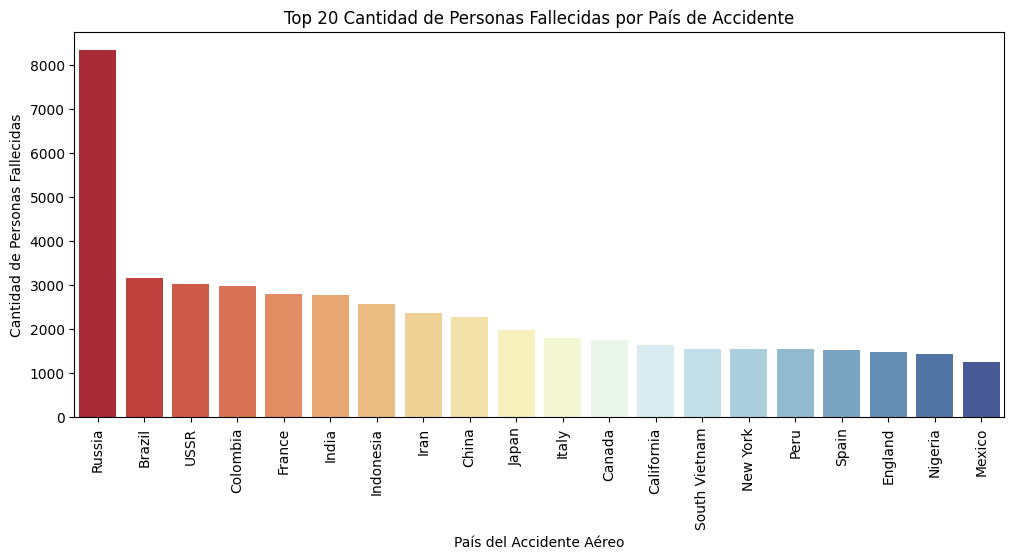

In [271]:
df_b2=df.groupby("country")["cantidad de fallecidos"].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,5))
sns.barplot(x=df_b2.index,y=df_b2,palette='RdYlBu')
plt.xlabel('País del Accidente Aéreo')
plt.ylabel('Cantidad de Personas Fallecidas')
plt.title('Top 20 Cantidad de Personas Fallecidas por País de Accidente')
plt.xticks(rotation=90);

CONCLUSIÓN: Al analizar el gráfico, se observa que Rusia es el país con la mayor cantidad de personas fallecidas. Esta tendencia puede explicarse al considerar el barplot previo que se realizó únicamente con la variable ``country,`` donde se evidencia que Rusia ha experimentado la mayor cantidad de accidentes aéreos en comparación con otros países. Sin embargo, comparando ambas gráficas es importante destacar que la relación entre la cantidad de accidentes y la cantidad de muertes no necesarimente es directamente proporcional. Es decir, no inevitablemnete el país con la mayor cantidad de accidentes tiene la mayor cantidad de muertes, ni el país con la menor cantidad de accidentes presenta la menor cantidad de muertes. Existen diferentes factores y circunstancias específicas que pueden influir en la cantidad de víctimas mortales en cada país.

***Exportación del data frame resultante para la realización de los Dashboards***

In [272]:
df.drop(columns="summary").to_csv("final_AccidentesAviones.csv",index=False)

---

## **Dataset: ``NTSB_aviation_2000-2022``**

### **ETL**

* #### **Carga de Datos**

In [111]:
df_ntsb=pd.read_csv("Datasets/NTSB_aviation_2000-2022.csv")
df_ntsb

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15584\3051051596.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ntsb=pd.read_csv("Datasets/NTSB_aviation_2000-2022.csv")


,NtsbNo,EventType,Mkey,EventDate,City,State,Country,ReportNo,N#,HasSafetyRec,Mode,ReportType,OriginalPublishedDate,HighestInjuryLevel,FatalInjuryCount,SeriousInjuryCount,MinorInjuryCount,ProbableCause,Findings,DocketUrl
0,GAA23WA050,ACC,106529,2022-12-31T19:00:00Z,Galvarino,Other Foreign,Chile,NaN,EC-LHJ,False,Aviation,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://data.ntsb.gov/Docket?ProjectID=106529
1,DCA23LA109,ACC,106517,2022-12-31T15:39:00Z,Montgomery,Alabama,United States,NaN,N264NN,False,Aviation,DirectorBrief,NaN,Fatal,1.0,0.0,0.0,NaN,NaN,https://data.ntsb.gov/Docket?ProjectID=106517
2,GAA23WA048,ACC,106523,2022-12-31T13:00:00Z,Prijedori,NaN,Bosnia And Herzegovina,NaN,E-PDH,False,Aviation,None,NaN,Fatal,2.0,0.0,0.0,NaN,NaN,https://data.ntsb.gov/Docket?ProjectID=106523
3,ERA23LA100,ACC,106533,2022-12-30T15:00:00Z,Dublin,Virginia,United States,NaN,N121,False,Aviation,DirectorBrief,NaN,None,0.0,0.0,0.0,NaN,NaN,https://data.ntsb.gov/Docket?ProjectID=106533
4,ENG23WA013,ACC,106606,2022-12-30T05:00:00Z,Venado,Other Foreign,Mexico,NaN,XB-SGV,False,Aviation,None,NaN,Fatal,2.0,0.0,0.0,NaN,NaN,https://data.ntsb.gov/Docket?ProjectID=106606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41177,LAX00LA062,ACC,48427,2000-01-02T14:30:00Z,DOS PALOS,California,United States,NaN,N7249T,False,Aviation,DirectorBrief,2001-12-14T05:00:00Z,Minor,0.0,0.0,1.0,A partial loss of engine power due to the fail...,NaN,https://data.ntsb.gov/Docket?ProjectID=48427
41178,DEN00FA037,ACC,48433,2000-01-02T09:50:00Z,TELLURIDE,Colorado,United States,NaN,N421CF,False,Aviation,DirectorBrief,2001-04-19T04:00:00Z,Fatal,1.0,0.0,0.0,The non-instrument rated pilot's intentional f...,NaN,https://data.ntsb.gov/Docket?ProjectID=48433
41179,DCA00WA018,INC,48766,2000-01-02T05:00:00Z,AMSTERDAM,NaN,Netherlands,NaN,PHHVV,False,Aviation,None,NaN,None,0.0,0.0,0.0,NaN,NaN,https://data.ntsb.gov/Docket?ProjectID=48766
41180,ATL00FA019,ACC,48389,2000-01-01T13:02:00Z,MONTEAGLE,Tennessee,United States,NaN,N8821V,False,Aviation,DirectorBrief,2001-04-19T04:00:00Z,Fatal,2.0,0.0,0.0,The pilot's failure to adequately evaluate wea...,NaN,https://data.ntsb.gov/Docket?ProjectID=48389


In [112]:
# Información del Dataset
df_ntsb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41182 entries, 0 to 41181
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NtsbNo                 41182 non-null  object 
 1   EventType              41182 non-null  object 
 2   Mkey                   41182 non-null  int64  
 3   EventDate              41182 non-null  object 
 4   City                   41159 non-null  object 
 5   State                  35917 non-null  object 
 6   Country                41143 non-null  object 
 7   ReportNo               87 non-null     object 
 8   N#                     41090 non-null  object 
 9   HasSafetyRec           41182 non-null  bool   
 10  Mode                   41182 non-null  object 
 11  ReportType             41182 non-null  object 
 12  OriginalPublishedDate  35887 non-null  object 
 13  HighestInjuryLevel     40779 non-null  object 
 14  FatalInjuryCount       40910 non-null  float64
 15  Se

* #### **Imputación de valores faltantes de la variable `Country`**

In [113]:
# Porcentaje de valores nulos (extremadamente bajo: 0.09%)
print(round((df_ntsb[df_ntsb.Country.isnull()].shape[0]/df_ntsb.shape[0])*100,2))

0.09


In [114]:
# Visualizando los valores faltantes
df_ntsb[df_ntsb.Country.isnull()][["City","State","Country"]]

,City,State,Country
26296,Atlantic Ocean,NaN,NaN
26518,London Control,NaN,NaN
26679,Atlantic Ocean,Atlantic Ocean,NaN
28397,Caribbean Sea,NaN,NaN
30184,Canada/US borde,NaN,NaN
30609,Atlantic Ocean,Atlantic Ocean,NaN
31366,Pacific Ocean,Pacific Ocean,NaN
31395,Caribbean Sea,NaN,NaN
31399,Gulf of Mexico,NaN,NaN
31452,"Appin, Scotland",NaN,NaN


In [115]:
"""
OBSERVACIÓN: De manera general solo se tomará la variable 'Country' y sus valores faltantes se imputarán con los valores 
de 'City' para no perder información del terrotorio del accidente aéreo.
"""
# También se homogieniza 'City' para que solo las iniciales de las palabras sean mayúsculas
df_ntsb["Country"]=df_ntsb.apply(lambda x: x.City.title() if pd.isnull(x.Country) else x.Country,axis=1)

* #### **Eliminación de columnas innecesarias**

Para el proyecto de Data Analytics se considerarán solo las siguientes columnas:
- ``EventType``: proporcionará información sobre el tipo de evento o accidente de aviación, lo que permitirá clasificar y categorizar los incidentes
- ``EventDate``: será fundamental para examinar las fechas en que ocurrieron los accidentes y comprender las tendencias y patrones a lo largo del tiempo. 
- ``Country``: nos permitirá analizar los accidentes por ubicación geográfica y evaluar las diferencias entre los países.
- Columnas relacionadas con las lesiones y muertes ``HighestInjuryLevel``, ``FatalInjuryCount``, ``SeriousInjuryCount`` y ``MinorInjuryCount``: nos proporcionarán información sobre el nivel de gravedad y la cantidad de lesiones fatales, graves y leves en cada accidente. Estos datos serán clave para comprender la magnitud de los accidentes y evaluar el impacto en la seguridad de la aviación.

In [116]:
df_ntsb=df_ntsb[["EventType","EventDate","Country","HighestInjuryLevel","FatalInjuryCount","SeriousInjuryCount","MinorInjuryCount"]]

* #### **Conversión de la variable `EventDate` a tipo datetime**

In [ ]:
df_ntsb["EventDate"]=pd.to_datetime(df_ntsb.EventDate,format="%Y-%m-%dT%H:%M:%SZ")

* #### **Imputación de valores faltantes de la columna `HighestInjuryLevel`**

In [120]:
# Porcentaje de valores nulos (extremadamente alto: 54.25%)
print(round((df_ntsb[(df_ntsb.HighestInjuryLevel.isnull())|(df_ntsb.HighestInjuryLevel=="None")].shape[0]/df_ntsb.shape[0])*100,2))

54.25


In [121]:
# Visualizando los valores únicos
df_ntsb.HighestInjuryLevel.unique()

array([nan, 'Fatal', 'None', 'Minor', 'Serious'], dtype=object)

In [ ]:
# Imputando con el valor 'unknown'
df_ntsb["HighestInjuryLevel"]=df_ntsb.HighestInjuryLevel.apply(lambda x: "unknown" if pd.isnull(x) or x=="None" else x)

* ##### **Imputación de valores faltantes de las columnas del tipo `float`**

Estos valores corresponden a la cantidad de personas involucradas en los accidentes de aviación. Estas columnas tienen la misma cantidad de valores faltantes según la información del dataset. El porcentaje de valores faltantes de estas variables es de 0.66%. Por lo cual, por ser un valor extremadamente bajo se imputará con el valor de cero para no alterar significativamente el análisis de datos.

In [125]:
print(round((df_ntsb[df_ntsb.FatalInjuryCount.isnull()].shape[0]/df_ntsb.shape[0])*100,2))

0.66


In [ ]:
# Imputando las columnas
for column in df_ntsb.columns:
    if df_ntsb[column].dtype=="float64":
        df_ntsb[column].fillna(0,inplace=True)
        df_ntsb[column]=df_ntsb[column].astype(int)

* ##### **Exportación del data frame resultante para la realización de los Dashboards**

In [127]:
df_ntsb.to_csv("final_NTSB_aviation_2000-2022.csv",index=False)

### **Análisis Exploratorio de Datos (EDA)**

#### **``Análisis Univariado``**

* #### **Estadísticas descriptivas de las variables numéricas**

In [132]:
df_ntsb.describe()

,FatalInjuryCount,SeriousInjuryCount,MinorInjuryCount
count,41182.000000,41182.000000,41182.000000
mean,0.633869,0.213418,0.323418
std,5.535665,1.157423,2.611694
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,295.000000,111.000000,380.000000


* #### **Diagrama de Cajas de las variables numéricas**

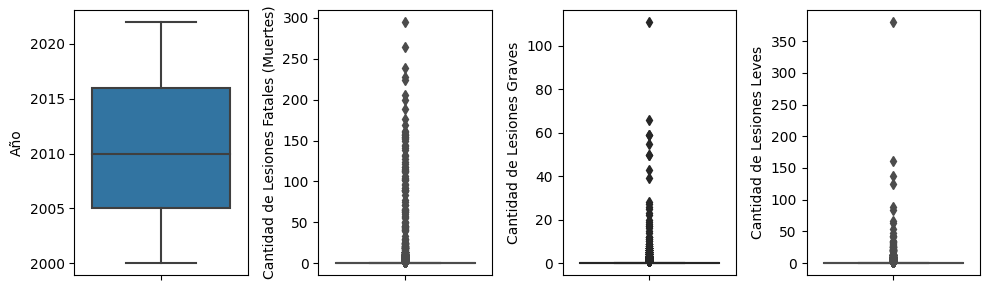

In [133]:
fig,ax=plt.subplots(1,4,figsize=(10,3))

sns.boxplot(y=df_ntsb.EventDate.dt.year,data=df_ntsb,ax=ax[0])
ax[0].set_ylabel("Año")

sns.boxplot(y="FatalInjuryCount",data=df_ntsb,ax=ax[1],color="red")
ax[1].set_ylabel("Cantidad de Lesiones Fatales (Muertes)")

sns.boxplot(y="SeriousInjuryCount",data=df_ntsb,ax=ax[2],color="green")
ax[2].set_ylabel("Cantidad de Lesiones Graves")

sns.boxplot(y="MinorInjuryCount",data=df_ntsb,ax=ax[3],color="#FFA500")
ax[3].set_ylabel("Cantidad de Lesiones Leves")

plt.tight_layout()

CONCLUSIÓN: Los años de la variable ``EventDate``  no presenta outliers, significando que los registros se distribuyen de manera relativamente uniforme a lo largo del tiempo sin eventos extremos o insuales. Por otro lado, las variables relacionadas con los tipos de lesiones sufridas por las personas en los accidentes aéreos presentan muchos valores atípicos superiores, tanto que los boxplots no se visualizan bien, lo cual sugiere que hay pocos casos en los que se produjeron un alto número de muertes y lesiones. 

* #### **Histogramas de las variables numéricas**

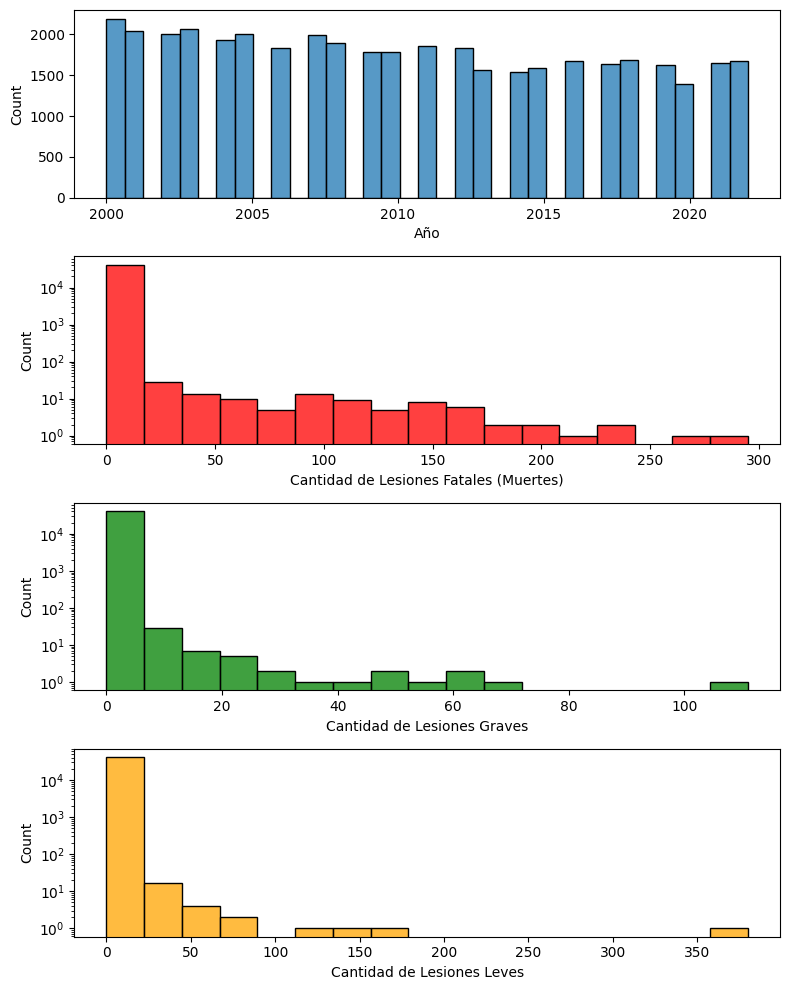

In [134]:
fig,ax=plt.subplots(4,1,figsize=(8,10))

sns.histplot(x=df_ntsb.EventDate.dt.year,data=df_ntsb,ax=ax[0])
ax[0].set_xlabel("Año")

sns.histplot(x="FatalInjuryCount",data=df_ntsb,ax=ax[1],color="red")
ax[1].set_xlabel("Cantidad de Lesiones Fatales (Muertes)")
ax[1].set(yscale="log")

sns.histplot(x="SeriousInjuryCount",data=df_ntsb,ax=ax[2],color="green")
ax[2].set_xlabel("Cantidad de Lesiones Graves")
ax[2].set(yscale="log")

sns.histplot(x="MinorInjuryCount",data=df_ntsb,ax=ax[3],color="#FFA500")
ax[3].set_xlabel("Cantidad de Lesiones Leves")
ax[3].set(yscale="log")

plt.tight_layout()

CONCLUSIÓN: La variable ``EventDate`` muestra una tendencia casi constante en la cantidad de accidentes a lo largo de los años, con pequeñas fluctuaciones. Sin embargo, al analizar las variables relacionadas con los tipos de lesiones, se observa una distribución sesgada hacia la derecha, con picos principales cerca de cero. Esto indica que en la mayoría de los accidentes aéreos, la cantidad de personas que fallecieron o sufrieron lesiones es baja o prácticamente nula. Estos hallazgos se refuerzan con los gráficos de boxplot previamente analizados

* #### **Gráficos de Barras de las variables categóricas**

Al visualizar los gráficos de barras se pueden extraer conclusiones visuales relevantes de manera rápida y efectiva.

##### Variable ``EventType``

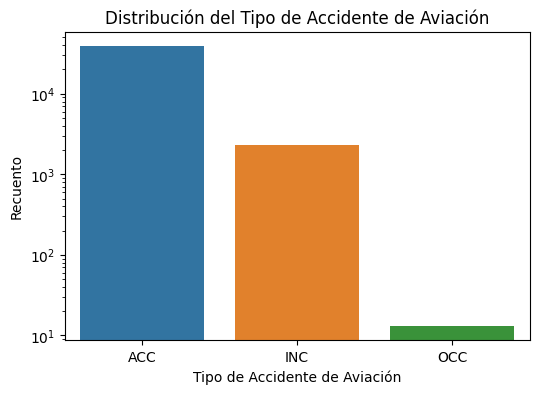

In [135]:
plt.figure(figsize=(6,4))
sns.countplot(x="EventType",data=df_ntsb)
plt.xlabel("Tipo de Accidente de Aviación")
plt.ylabel("Recuento")
plt.yscale("log")
plt.title("Distribución del Tipo de Accidente de Aviación");

`Información adicional del tipo de Accidente Aéreo:`
* ``ACC``: Se refiere a eventos de "Accidente". Este valor indica que el incidente reportado involucró un accidente de aviación, es decir, una situación en la cual una aeronave se vio involucrada en un suceso no deseado, generalmente con consecuencias negativas como daños a la aeronave, lesiones o pérdida de vidas.

* ``INC``: Representa eventos de "Incidente". Este valor se utiliza para indicar que el incidente reportado no fue un accidente completo, sino más bien una situación peligrosa o insegura que pudo haber llevado a un accidente pero que no tuvo consecuencias graves. Por lo general, los incidentes son eventos que podrían haber resultado en un accidente, pero fueron evitados o mitigados a tiempo.

* ``OCC``: Significa "Otro Ocaso". Este valor se utiliza para clasificar eventos o circunstancias que no se consideran ni accidentes ni incidentes. Puede incluir situaciones especiales, eventos de mantenimiento, eventos relacionados con la operación de la aeronave, entre otros.

##### Variable ``HighestInjuryLevel``

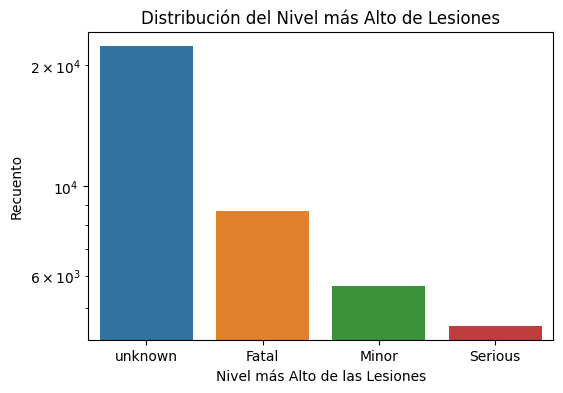

In [136]:
plt.figure(figsize=(6,4))
sns.countplot(x="HighestInjuryLevel",data=df_ntsb)
plt.xlabel("Nivel más Alto de las Lesiones")
plt.ylabel("Recuento")
plt.yscale("log")
plt.title("Distribución del Nivel más Alto de Lesiones");

##### Variable ``Country``

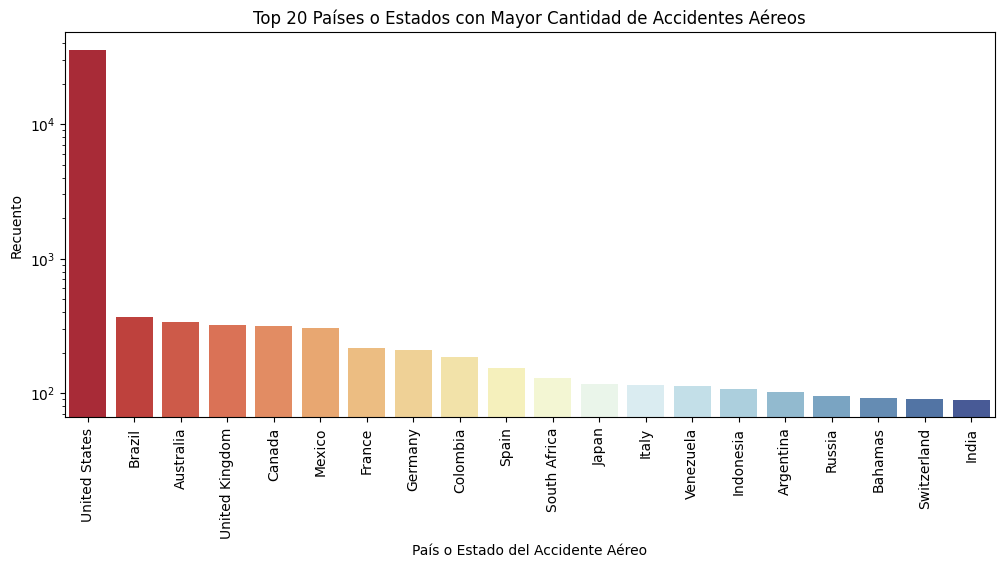

In [142]:
top_country=df_ntsb.Country.value_counts().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,5))
sns.barplot(x=top_country.index,y=top_country,palette='RdYlBu')
plt.xlabel('País o Estado del Accidente Aéreo')
plt.ylabel('Recuento')
plt.yscale("log")
plt.title('Top 20 Países o Estados con Mayor Cantidad de Accidentes Aéreos')
plt.xticks(rotation=90);

#### **``Análisis Bivariado``**

* #### **Heatmap de las variables numéricas**

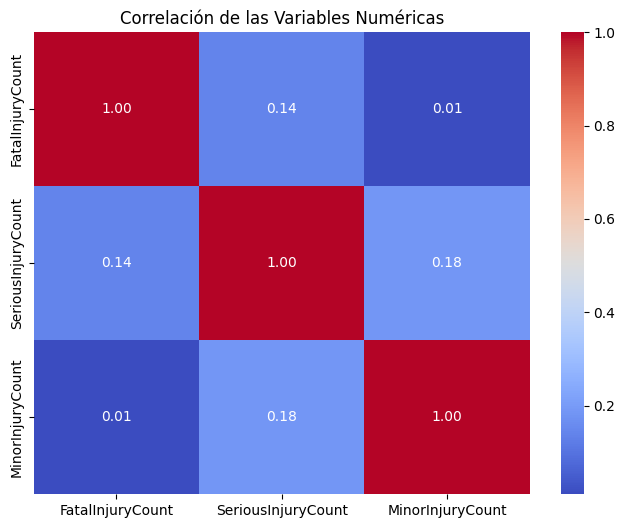

In [145]:
plt.figure(figsize=(8,6))
sns.heatmap(df_ntsb.corr(numeric_only=True),annot=True,fmt=".2f",cmap="coolwarm")
plt.title("Correlación de las Variables Numéricas");

CONCLUSIÓN: Después de realizar un análisis, se ha observado que no se encuentra una correlación significativa entre las variables asociadas a los tipos de lesiones. Aunque se ha encontrado una correlación positiva, el valor máximo obtenido es de 0.18. En base a este resultado, se concluye que el aumento en una variable tiene un impacto mínimo en el aumento de la otra variable.

* #### **Barplot: Cantidad de Personas Fallecidas (Lesión Fatal) por Año**

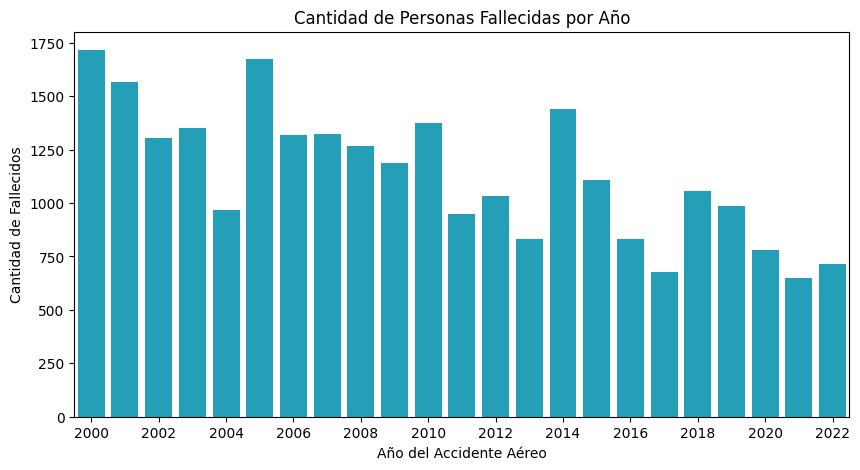

In [155]:
df_b1=df_ntsb.groupby(df_ntsb.EventDate.dt.year)["FatalInjuryCount"].sum()
plt.figure(figsize=(10,5))
plt.title("Cantidad de Personas Fallecidas por Año")
sns.barplot(x=df_b1.index,y=df_b1,color="#0bb0d0")
plt.xlabel("Año del Accidente Aéreo")
plt.xticks(range(0,len(df_b1.index),2),df_b1.index[::2])
plt.ylabel("Cantidad de Fallecidos");

CONCLUSIÓN: Al observar la distribución del gráfico, se puede apreciar que varios años, como 2000, 2005 y 2001, presentan un elevado número de muertes debido a accidentes aéreos. Por otro lado, se observan pequeñas fluctuaciones con un bajo número de muertes, como en los años 2017 y 2021. Esta variabilidad en la cantidad de muertes a lo largo de los años indica que no existe una tendencia constante en los accidentes aéreos y que la seguridad ha experimentado mejoras en algunos períodos, mientras que en otros ha habido un notable incremento de los accidentes.

* #### **Barplot: Cantidad de Personas Fallecidas por País de Accidente**

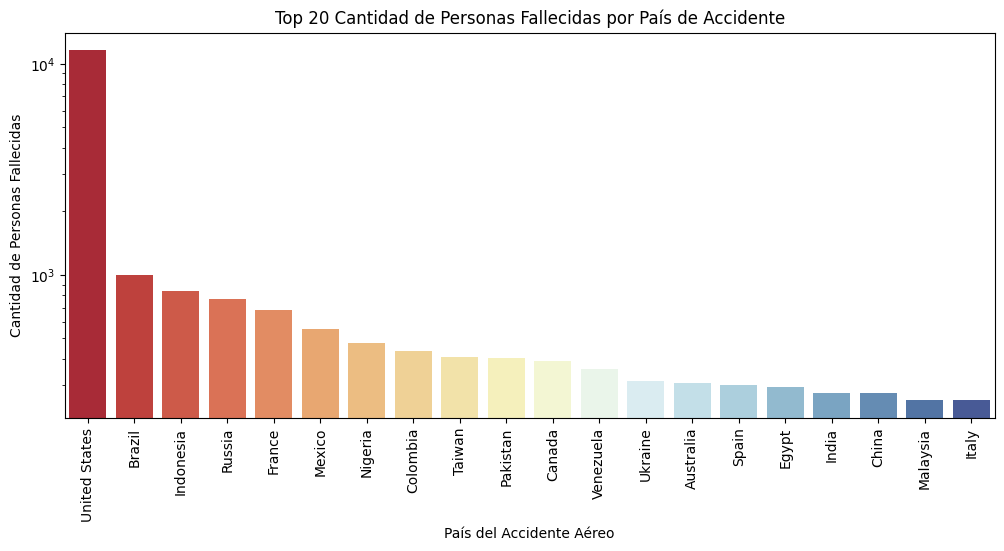

In [158]:
df_b2=df_ntsb.groupby("Country")["FatalInjuryCount"].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,5))
sns.barplot(x=df_b2.index,y=df_b2,palette='RdYlBu')
plt.xlabel('País del Accidente Aéreo')
plt.ylabel('Cantidad de Personas Fallecidas')
plt.yscale("log")
plt.title('Top 20 Cantidad de Personas Fallecidas por País de Accidente')
plt.xticks(rotation=90);

CONCLUSIÓN: Estados Unidos tiene la mayor cantidad de fallecidos en accidentes aéreos, como se refleja en el gráfico anterior que muestra la variable ``Country``. Sin embargo, al comparar ambas gráficas, se nota que la relación entre la cantidad de accidentes y el número de muertes no es necesariamente proporcional. Esto significa que el país con más accidentes no siempre tiene la mayor cantidad de muertes, y el país con menos accidentes no siempre tiene la menor cantidad de muertes. La cantidad de víctimas mortales en cada país está influenciada por diversos factores y circunstancias específicas.